# Bias-correct capacity factors for each REZ

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# client.close()
# cluster.close()

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "01:00:00"
cores = 48
memory = str(4 * cores) + "GB"

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=["-q normal",
                                           "-P dt6",
                                           "-l ncpus="+str(cores),
                                           "-l mem="+str(memory),
                                           "-l storage=gdata/w42+gdata/rt52+scratch/dt6"],
                     local_directory="$TMPDIR",
                     job_directives_skip=["select"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.12:36751,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
import xarray as xr
import pandas as pd

In [6]:
%cd /g/data/w42/dr6273/work/power_models
import functions as fn

/g/data/w42/dr6273/work/power_models


In [7]:
%load_ext autoreload
%autoreload 2

# Load data

REZ mask

In [8]:
mask = xr.open_dataset('/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_2024_mask_era5_grid.nc').REZ

In [9]:
mask

<xarray.DataArray 'REZ' (region: 43, lat: 141, lon: 181)> Size: 1MB
[1097403 values with dtype=bool]
Coordinates:
  * lat          (lat) float32 564B -10.0 -10.25 -10.5 ... -44.5 -44.75 -45.0
  * lon          (lon) float32 724B 110.0 110.2 110.5 ... 154.5 154.8 155.0
  * region       (region) <U3 516B 'Q1' 'Q2' 'Q3' 'Q4' ... 'T1' 'T2' 'T3' 'T4'
    region_code  (region) int64 344B ...
    latitude     (region) float64 344B ...
    longitude    (region) float64 344B ...

REZ capacity factors from ISP

In [10]:
def read_cfs(fuel_type):
    """
    Read and process AEMO ISP capacity factor data
    
    fuel_type: str, "wind_medium", "wind_high", "solarpv", "offshorewind_fixed" or "offshorewind_floating"
    """
    def p2f(x):
        return x.str.rstrip('%').astype('float') / 100.0#float(x.strip('%'))/100

    years = range(2011, 2024) # years of data
    
    df = pd.read_csv("rez_capacity_factors_" + fuel_type + ".csv", skiprows=2, index_col=0) # Read data
    df.columns = ["REZ_name", "Region"] + [int(y) for y in years] + ["Avg"] # rename columns
    df = df.dropna(axis=0) # Drop rows with NaN (i.e., zero capacity)
    df = df.drop(["REZ_name", "Region"], axis=1) # Drop columns
    
    return df.apply(p2f) # Convert percentage strings to float

In [11]:
isp_cfs = {}
for fuel_type in ["wind_medium", "wind_high", "solarpv"]:
    isp_cfs[fuel_type] = read_cfs(fuel_type)

In [12]:
# concat Onshore wind with offshore
_offshore = read_cfs("offshorewind_fixed")
isp_cfs["wind_medium"] = pd.concat([isp_cfs["wind_medium"], _offshore])
isp_cfs["wind_high"] = pd.concat([isp_cfs["wind_high"], _offshore])

In [13]:
isp_cfs["wind_high"].tail()

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Avg
N11,0.42,0.39,0.42,0.43,0.41,0.40,0.41,0.42,0.40,0.41,0.41,0.41,0.43,0.41
V7,0.46,0.45,0.45,0.48,0.45,0.46,0.47,0.48,0.47,0.50,0.48,0.49,0.46,0.47
V8,0.43,0.46,0.45,0.47,0.43,0.43,0.44,0.45,0.45,0.48,0.45,0.48,0.44,0.45
S10,0.42,0.46,0.44,0.48,0.44,0.44,0.43,0.45,0.46,0.47,0.44,0.48,0.45,0.45
T4,0.48,0.49,0.46,0.51,0.46,0.47,0.48,0.50,0.50,0.52,0.49,0.50,0.47,0.49


# Example - REZ Q1

Raw capacity factor data

In [15]:
r = "Q1"
gen_type = "wind"
method = "van_der_Wiel"

In [16]:
years = range(2011, 2024)

In [50]:
da_list = []
for y in years:
    cf = fn.load_hourly_cf(y, gen_type, method=method, add_dir="", chunks={"lat": -1, "lon": -1, "time": 2500}).capacity_factor
    cf = cf.where(mask.sel(region=r) == 1, drop=True)
    da_list.append(cf)
cf_r = xr.concat(da_list, dim="time")

In [51]:
cf_r.nbytes / 1024 ** 3

0.04457294940948486

In [19]:
# cf_r = cf_r.compute()

Mean CF by grid cell

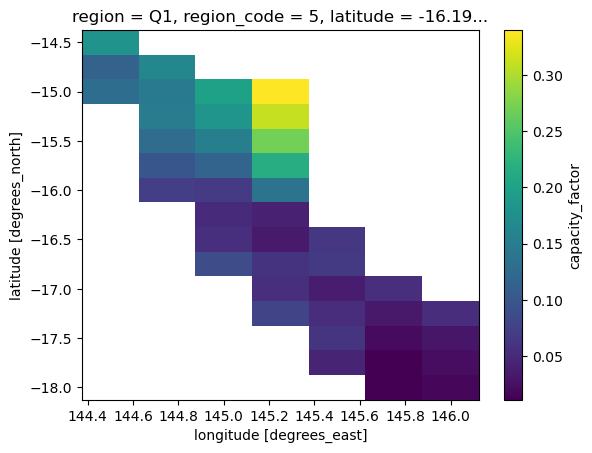

In [20]:
cf_r.mean("time").plot()

Mean cf over REZ

In [21]:
cf_r.mean().compute()

<xarray.DataArray 'capacity_factor' ()> Size: 4B
array(0.10014703, dtype=float32)
Coordinates:
    region       <U3 12B 'Q1'
    region_code  int64 8B 5
    latitude     float64 8B -16.19
    longitude    float64 8B 145.1

Difference with AEMO CF

In [22]:
obs_mean = isp_cfs["wind_medium"].loc[r]["Avg"]
obs_mean

0.42

In [23]:
obs_mean - cf_r.mean().compute()

<xarray.DataArray 'capacity_factor' ()> Size: 8B
array(0.31985297)
Coordinates:
    region       <U3 12B 'Q1'
    region_code  int64 8B 5
    latitude     float64 8B -16.19
    longitude    float64 8B 145.1

# Bias correct

In [14]:
import numpy as np
from scipy.optimize import root_scalar

In [15]:
def find_logit_correction(x_model_da, mu_obs, eps=1e-6):
    """
    Bias correct an xarray.DataArray using logit transform + constant shift,
    such that the mean of the corrected data matches mu_obs.
    
    Parameters:
    -----------
    x_model_da : xr.DataArray
        Input data in the range (0, 1), with dims like (lat, lon, time).
        NaNs are supported and will be ignored in the correction.
        
    mu_obs : float
        Target mean to match after correction.
        
    eps : float
        Small value to clip data away from 0 and 1 before applying logit.
    
    Returns:
    --------
    xr.DataArray
        Bias-corrected data with the same shape and coordinates as input.
    """
    
    # Flatten non-NaN values for correction
    x_flat = x_model_da.values.flatten()
    mask_valid = ~np.isnan(x_flat)
    x_valid = x_flat[mask_valid]
    
    # Clip to avoid logit problems at 0 and 1
    x_valid = np.clip(x_valid, eps, 1 - eps)
    z = np.log(x_valid / (1 - x_valid))

    # Define function to match corrected mean to target
    def mean_diff(c):
        z_corr = z + c
        x_corr = 1 / (1 + np.exp(-z_corr))
        return np.mean(x_corr) - mu_obs

    # Solve for c using root finding
    result = root_scalar(mean_diff, bracket=[-10, 10], method='bisect')
    if not result.converged:
        raise RuntimeError("Failed to find bias correction shift")

    c = result.root
    return c

In [16]:
def logit_bias_correct(x_model_da, c, eps=1e-6):
    # Apply correction to full (non-NaN) data
    x_clipped = x_model_da.clip(min=eps, max=1 - eps)
    z_full = np.log(x_clipped / (1 - x_clipped))
    z_corrected = z_full + c
    x_corrected = 1 / (1 + np.exp(-z_corrected))

    # Return as DataArray with same coords
    return xr.DataArray(
        x_corrected,
        dims=x_model_da.dims,
        coords=x_model_da.coords,
        attrs=x_model_da.attrs
    )

In [53]:
c = find_logit_correction(cf_r, obs_mean)

In [54]:
c

2.9012199640271774

In [57]:
%%time
cf_r_bc = logit_bias_correct(cf_r, c).compute()

CPU times: user 590 ms, sys: 106 ms, total: 696 ms
Wall time: 863 ms


In [17]:
import matplotlib.pyplot as plt

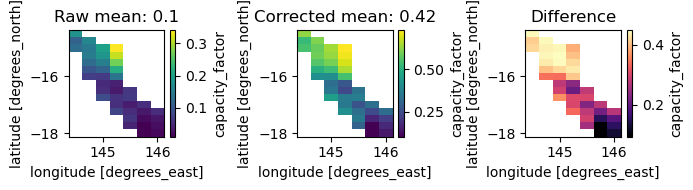

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(7,2))

# Raw capacity factors
r_mean = np.round(cf_r.mean(skipna=True).values, 2)
cf_r.mean("time").plot(ax=ax[0])
ax[0].set_title("Raw mean: "+str(r_mean))

# Corrected capacity factors
r_mean = np.round(cf_r_bc.mean(skipna=True).values, 2)
cf_r_bc.mean("time").plot(ax=ax[1])
ax[1].set_title("Corrected mean: "+str(r_mean))

# Difference
(cf_r_bc - cf_r).mean("time").plot(ax=ax[2], cmap="magma")
ax[2].set_title("Difference")

plt.tight_layout()

### Out of sample

In [18]:
def crossval_bias_correct_leave_one_year_out(x_model, mu_obs_series, eps=1e-6):
    """
    Perform leave-one-year-out bias correction using logit-shift.

    Parameters
    ----------
    x_model : xr.DataArray
        Modelled data in (0, 1), dims must include 'time' with datetime dtype.
    mu_obs_series : pd.Series
        Observed means indexed by year, where each value is the mean of all years except that one.
        Example: mu_obs_series.loc[2011] = mean(obs excluding 2011)
    eps : float
        Small value to clip values away from 0 and 1.

    Returns
    -------
    xr.DataArray
        Corrected model data, with each year corrected using mu_obs from all other years.
    """
    corrected_years = []

    for year in mu_obs_series.index:
        # Get modelled data for this year
        x_model_year = x_model.sel(time=x_model['time.year'] == year)
        
        # Get modelled data for other years
        x_model_other = x_model.sel(time=x_model['time.year'] != year)

        # Use the precomputed mean for all years except this one
        mu_obs = mu_obs_series.loc[year]

        # Find bias between observed and modelled calibration years
        c = find_logit_correction(x_model_other, mu_obs)
        # print(c)
        
        # Apply bias correction to this year
        x_corrected_year = logit_bias_correct(x_model_year, c, eps=eps)
        # x_corrected_year = logit_bias_correct_dataarray(x_model_year, mu_obs, eps=eps)

        corrected_years.append(x_corrected_year)

    # Concatenate all years and sort by time
    return xr.concat(corrected_years, dim='time').sortby('time')

In [19]:
def leave_one_out_means(mu_obs_series):
    """
    Return a Series where each entry is the mean of all other entries.
    
    mu_obs_series: pandas Series
    """
    total_sum = mu_obs_series.sum()
    n = len(mu_obs_series)
    return (total_sum - mu_obs_series) / (n - 1)

In [73]:
mu_obs_excl = leave_one_out_means(
    isp_cfs["wind_medium"].loc[r].copy().drop("Avg", axis=0)
)

In [74]:
%%time
cf_r_bc = crossval_bias_correct_leave_one_year_out(cf_r, mu_obs_excl)

2.9103583097446517
2.9081078767774216
2.895410895347368
2.9065052270891556
2.9032360315329697
2.9061833620073685
2.9215396642678115
2.898939251900856
2.935301661490257
2.918079972267833
2.907756924629439
2.909875512124245
2.9545530080793014
CPU times: user 20.5 s, sys: 7.68 s, total: 28.2 s
Wall time: 27.7 s


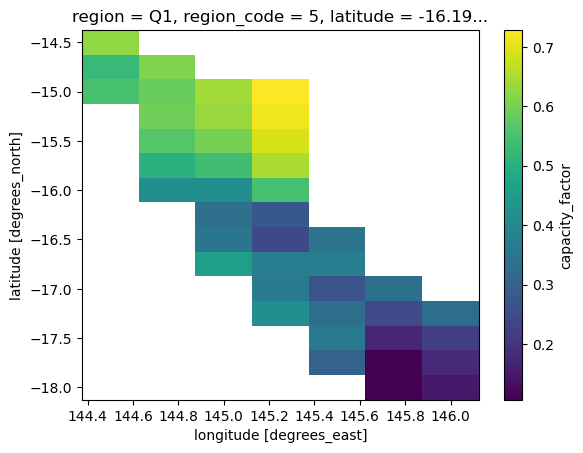

In [75]:
cf_r_bc.mean("time").plot()

In [77]:
cf_r_bc.mean().compute()

<xarray.DataArray 'capacity_factor' ()> Size: 4B
array(0.42157096, dtype=float32)
Coordinates:
    region       <U3 12B 'Q1'
    region_code  int64 8B 5
    latitude     float64 8B -16.19
    longitude    float64 8B 145.1

Text(0.5, 1.0, 'Q1 annual mean capacity factor')

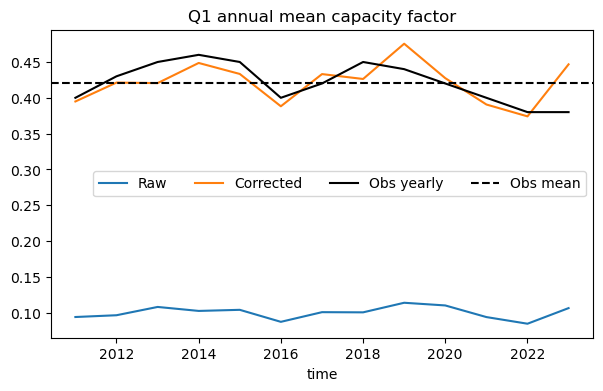

In [78]:
fig, ax = plt.subplots(figsize=(7,4))

cf_r.mean(["lat", "lon"]).resample(time="1YS").mean().plot(label="Raw")

_c = cf_r_bc.mean(["lat", "lon"]).resample(time="1YS").mean()
_c.plot(label="Corrected")

xr.DataArray(isp_cfs["wind_medium"].loc[r].copy().drop("Avg", axis=0).values, dims=_c.dims, coords=_c.coords).plot(label="Obs yearly", c="k")

ax.axhline(isp_cfs["wind_medium"].loc[r].copy()["Avg"], c="k", ls="--", label="Obs mean")

ax.legend(ncols=4)
ax.set_title("Q1 annual mean capacity factor")

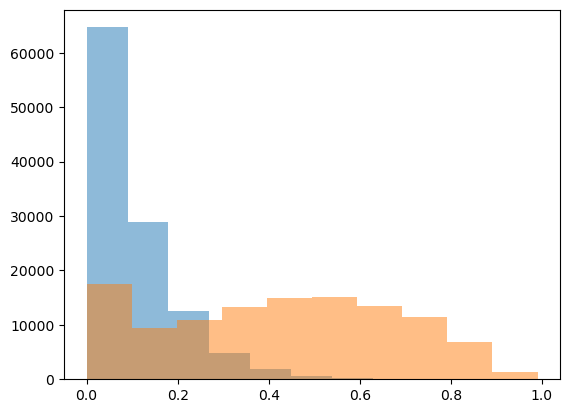

In [80]:
_ = plt.hist(cf_r.mean(["lat", "lon"]), alpha=0.5)
_ = plt.hist(cf_r_bc.mean(["lat", "lon"]), alpha=0.5)

# Process for all REZs

Raw capacity factor data

In [20]:
method = "van_der_Wiel"

In [21]:
all_years = range(1940, 2024)
calib_years = range(2011, 2024)

In [25]:
for (gen_type, cf_type) in zip(["solar", "wind", "wind", "solar"], ["solarpv", "wind_medium", "wind_high"]):
    print(gen_type, cf_type)
    cf_path = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/" + gen_type + "/capacity_factor/" + method + "/bias_corrected/"

    for r in mask.region.values:
        
        # Check if this REZ has an observed capacity factor
        check_rez = r in isp_cfs[cf_type].index
        
        if check_rez:

            # Load capacity factors for this region only
            da_list = []
            for y in all_years:
                cf = fn.load_hourly_cf(y, gen_type, method=method, add_dir="", chunks={"lat": -1, "lon": -1, "time": 2500}).capacity_factor
                cf = cf.where(mask.sel(region=r) == 1, drop=True)
                da_list.append(cf)
            cf = xr.concat(da_list, dim="time")

            # Observed means
            mu_obs_all = isp_cfs[cf_type].loc[r].copy()["Avg"]

            # Data in calibration period
            cf_calib = cf.sel(time=cf["time.year"].isin(calib_years))

            # Correction factor over calibration period
            c = find_logit_correction(cf_calib, mu_obs_all)

            # Bias correct all data
            cf_bc = logit_bias_correct(cf, c)

            # to dataset, re-chunk and write
            cf_bc = cf_bc.chunk({"time": -1})
            cf_bc = cf_bc.to_dataset(name="capacity_factor")
            cf_bc.to_netcdf(
                cf_path + cf_type + "_capacity_factor_" + method + "_era5_hourly_1940-2023_" + r + ".nc",
                mode="w"
            )
            
        else:
            pass

solar solarpv
wind wind_medium
wind wind_high


In [26]:
isp_cfs["wind_high"]

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Avg
Q1,0.43,0.46,0.47,0.49,0.48,0.43,0.46,0.49,0.49,0.46,0.44,0.42,0.42,0.46
Q2,0.41,0.42,0.43,0.45,0.43,0.39,0.41,0.43,0.45,0.41,0.41,0.38,0.39,0.42
Q4,0.32,0.32,0.34,0.37,0.34,0.33,0.34,0.34,0.39,0.33,0.36,0.35,0.34,0.34
Q5,0.33,0.31,0.35,0.34,0.35,0.32,0.32,0.33,0.36,0.31,0.32,0.31,0.30,0.33
Q6,0.37,0.38,0.37,0.37,0.37,0.35,0.36,0.35,0.41,0.34,0.38,0.36,0.35,0.37
Q7,0.30,0.30,0.30,0.28,0.29,0.28,0.28,0.29,0.31,0.27,0.29,0.29,0.29,0.29
Q8,0.38,0.37,0.37,0.35,0.38,0.36,0.35,0.37,0.39,0.36,0.38,0.40,0.38,0.37
Q9,0.30,0.30,0.30,0.29,0.30,0.28,0.29,0.30,0.32,0.28,0.30,0.30,0.28,0.30
N2,0.39,0.36,0.38,0.36,0.37,0.37,0.37,0.38,0.39,0.38,0.40,0.41,0.39,0.38
N3,0.37,0.34,0.35,0.34,0.35,0.34,0.34,0.36,0.35,0.37,0.36,0.37,0.36,0.35
